
# ロジスティック回帰(logistic regression)

ひらがな判定をする。72種類

ライブラリ読み込み

In [1]:
import numpy as np
import scipy
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

データの読み込み

In [2]:
ary = np.load("./../data/hiragana.npz")['arr_0'].reshape([-1, 127, 128]).astype(np.float32) / 15
ary.shape

(11520, 127, 128)

入力データの取得

In [3]:
# 分類クラス数
nb_classes = 72
# サイズを変換する (127, 128) => (32, 32)
img_height, img_width = 32, 32

X_data = np.zeros([nb_classes * 160, img_height, img_width], dtype=np.float32)
for i in range(nb_classes * 160):
    # 画像をリサイズする
    X_data[i] = scipy.misc.imresize(ary[i], (img_height, img_width), mode='F')
Y_data = np.repeat(np.arange(nb_classes), 160)

del ary

データの表示

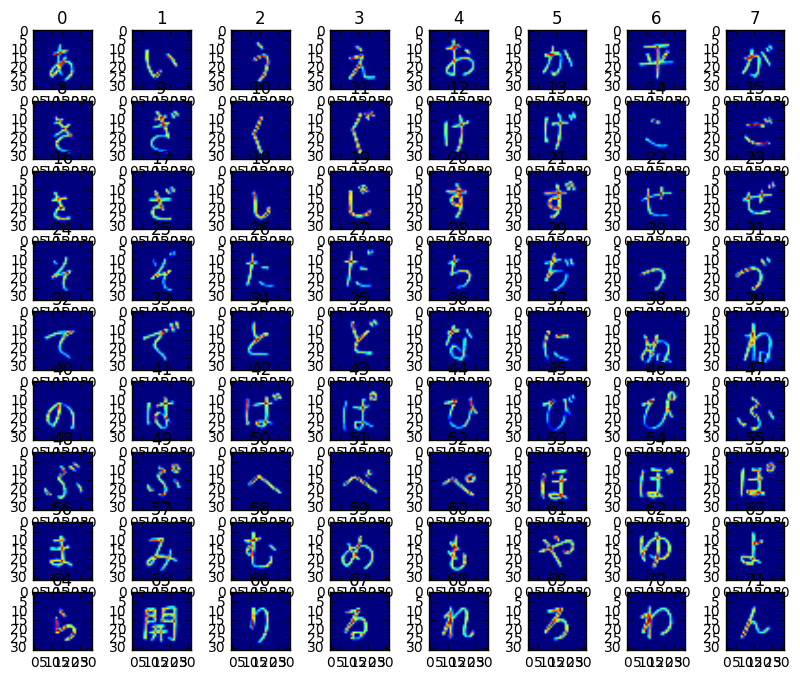

In [4]:
fig = plt.figure(figsize=(10, 8)) # 図形の大きさを(x, y)で指定

for index in np.arange(0, nb_classes):
    plot = fig.add_subplot(9, 8, index + 1)
    plot.imshow(X_data[160*index])
    plot.set_title(Y_data[160*index])

plt.show()

ロジスティック回帰の入力にあわせるため、2次元を1次元にする

(11520, 32, 32) => (11520, 1024) # 1024 = 32*32

In [5]:
X_data = X_data.reshape(X_data.shape[0], img_height * img_width)
X_data.shape

(11520, 1024)

データセットをトレーニングセットとCVに分ける（8:2)

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.2)

print('dataset:', X_data.shape, Y_data.shape)
print('train set:', X_train.shape, Y_train.shape)
print('cv set:', X_val.shape, Y_val.shape)

dataset: (11520, 1024) (11520,)
train set: (9216, 1024) (9216,)
cv set: (2304, 1024) (2304,)


one-hot vectorに変換する

In [7]:
def to_categorical(y, nb_classes=None):
    y = np.array(y, dtype='int').ravel()
    if not nb_classes:
        nb_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, nb_classes))
    categorical[np.arange(n), y] = 1
    return categorical

Y_train = to_categorical(Y_train, nb_classes)
Y_val = to_categorical(Y_val, nb_classes)
Y_train[0], Y_val[0]

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]))

In [8]:
print('train set:', X_train.shape, Y_train.shape)
print('cv set:', X_val.shape, Y_val.shape)

train set: (9216, 1024) (9216, 72)
cv set: (2304, 1024) (2304, 72)


グラフの入力を定義

In [9]:
X = tf.placeholder(tf.float32, [None, img_height * img_width]) # 入力数: 32x32 = 1,024
y = tf.placeholder(tf.float32, [None, nb_classes]) # 分類するクラス数: 72

モデルの重み$W$とバイアス$b$を定義

In [10]:
W = tf.Variable(tf.zeros([img_height * img_width, nb_classes]))
b = tf.Variable(tf.zeros([nb_classes])) 

モデルの定義

行列演算をして、softmaxにかける。ブロードキャスティングしている
(batch_size, 1024) x (1024, 72) + (72) = (batch_size, 72)

In [11]:
y_pred = tf.nn.softmax(tf.add(tf.matmul(X, W), b))

精度測定の定義

In [12]:
# 正しいかの予測
# 計算された画像がどの数字であるかの予測yと正解ラベルy_を比較する
# 同じ値であればTrueが返される
# argmaxは配列の中で一番値の大きい箇所のindexが返される
# 一番値が大きいindexということは、それがその数字である確率が一番大きいということ
# Trueが返ってくるということは訓練した結果と回答が同じということ
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_pred,1))

# 精度の計算
# correct_predictionはbooleanなのでfloatにキャストし、平均値を計算する
# Trueならば1、Falseならば0に変換される
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

cross_entropy(交差エントロピー誤差)の定義

$$
E = - \sum_k t_k log y_k
$$

In [13]:
cost = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_pred), reduction_indices=1))

最適化を勾配降下法で定義
学習率: 0.01

In [14]:
update = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

学習の実施

In [15]:
train_hist = []
val_hist = []
batch_size = 100

with tf.Session() as sess:
    # Variableの初期化
    sess.run(tf.initialize_all_variables())

    # 3000回トレーニングする
    for epoch in range(3000):
        avg_cost = 0.0
        nb_batch = int(X_train.shape[0] / batch_size) # バッチループ数: 11520 / 100 = 115.2
        for i in range(nb_batch):
            start =  i * batch_size
            end = start + batch_size
            batch_xs, batch_ys = X_train[start:end], Y_train[start:end]
            _, cost_v = sess.run([update, cost], feed_dict={X: batch_xs, y: batch_ys})
            avg_cost += cost_v / nb_batch
        
        # 100エポックごとに進捗を表示
        if (epoch+1) % 100 == 0:
            train_acc = accuracy.eval(feed_dict={X: batch_xs, y: batch_ys})
            val_acc = accuracy.eval(feed_dict={X: X_val, y: Y_val})
            train_hist.append(train_acc)
            val_hist.append(val_acc)
            print("Epoch: {:04d}, cost={:.9f}, train acc={:.5f}, val acc={:.5f}".format(
                        (epoch+1), avg_cost, train_acc, val_acc))
            
    print("Complete")

Epoch: 0100, cost=3.874449388, train acc=0.41000, val acc=0.32943
Epoch: 0200, cost=3.549463998, train acc=0.52000, val acc=0.45486
Epoch: 0300, cost=3.283801478, train acc=0.55000, val acc=0.49783
Epoch: 0400, cost=3.064132968, train acc=0.54000, val acc=0.52257
Epoch: 0500, cost=2.880643000, train acc=0.56000, val acc=0.53950
Epoch: 0600, cost=2.725944877, train acc=0.57000, val acc=0.54818
Epoch: 0700, cost=2.594323461, train acc=0.57000, val acc=0.55729
Epoch: 0800, cost=2.481311513, train acc=0.57000, val acc=0.56424
Epoch: 0900, cost=2.383406662, train acc=0.58000, val acc=0.56988
Epoch: 1000, cost=2.297856147, train acc=0.58000, val acc=0.57552
Epoch: 1100, cost=2.222487546, train acc=0.58000, val acc=0.57943
Epoch: 1200, cost=2.155576655, train acc=0.59000, val acc=0.58507
Epoch: 1300, cost=2.095746460, train acc=0.59000, val acc=0.58984
Epoch: 1400, cost=2.041889652, train acc=0.59000, val acc=0.59375
Epoch: 1500, cost=1.993110078, train acc=0.61000, val acc=0.59592
Epoch: 160

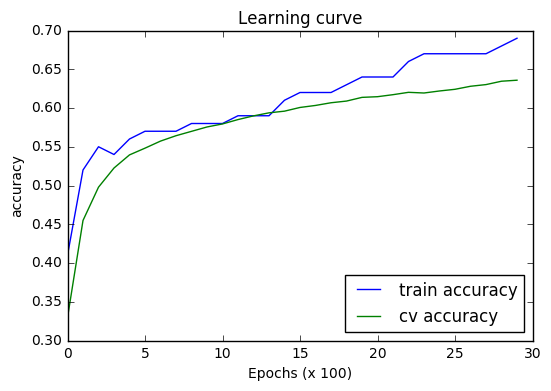

In [16]:
# 学習曲線を引く
xlin = range(0, len(train_hist))
plt.plot(xlin, train_hist, color='blue', label='train accuracy')
plt.plot(xlin, val_hist, color='green', label='cv accuracy')
plt.title('Learning curve')
plt.xlabel('Epochs (x 100)')
plt.ylabel('accuracy')
plt.legend( ('train accuracy', 'cv accuracy'), loc='lower right')
plt.show()